# Project 5 - Hear Us: Toward a More Just World

## Table of Contents

- [Table of Contents](#Table-of-Contents)
- [Problem Statement](#Problem-Statement)
- [Imports](#Imports)
- [Munging](#Munging)
- [Functions](#Functions)
- [EDA](#EDA)
- [Modeling](#Modeling)
- [Model Results](#Model-Results)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Problem Statement

With an average of over 600 noteworthy protests occurring globally per year, and just 10% succeeding in achieving a positive government response toward their aims, international human rights organizations face a dismal kind of triage.  Where can we devote resources to greatest effect, and where will they be wasted?  How can we turn a failure into a success?

We seek to leverage extensive data, compiled by the CIA, on the demographics of hundreds of nations and the thousands of mass movements that have arisen over the past two decades and change, in building a highly-interpretable predictive model of protest success.  The insights gained from machine learning will inform Amnesty International's budgeting of both efforts and funds to new movements as they unfold.

Furthermore, state-sanctioned violence is an all-too common response to popular movements.  Independently of our predictions of success, we will indentify indicators of which protests are most vulnerable to violence at the hands of state actors.  By predicting this in advance, we enable Amnesty to direct media attention _before_ violence erupts -- often the most effective way to prevent it.

## Imports

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, textwrap, gensim.downloader as api

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN

from collections import Counter
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras import metrics

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re

plt.style.use('dark_background')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [2]:
africa = pd.read_csv('./data/africa.csv')
asia = pd.read_csv('./data/asia.csv')
cen_am = pd.read_csv('./data/central_america.csv')
europe = pd.read_csv('./data/europe.csv')
mena = pd.read_csv('./data/mena.csv')
nor_am = pd.read_csv('./data/north_america.csv')
oceania = pd.read_csv('./data/oceania.csv')
sou_am = pd.read_csv('./data/south_america.csv')
world = pd.read_csv('./data/global.csv')
df = pd.read_csv('./data/global_cia_combined.csv')

# df_orig = pd.read_csv('../data/mmALL_073120_csv.csv')

## Munging

Extensive cleanup was needed on the Participants column.  This was one of the most time-intensive portions of our data prep, but it was deemed necessary to make such an important feature usable.

The work paid off, as it not only gave us our first logreg to actually beat the null model, but it hit an impressive 93.8% from adding this feature alone.

In [3]:
# J's cleanup of participants column

# extensive manual imputation, but I think it all holds up to common sense
# and I applied it consistently.  I welcome scrutiny for any mistakes.

part_dic = {"100s": 500, "1000s": 5000, "50": 50, "50+": 75, "100": 100,
            "1000": 1000, "10000": 10000, "200": 200, "2000": 2000,
            "thousands": 5000, "300": 300, "500": 500, "5000": 5000,
            "10000s": 50000, "hundreds": 500, "3000": 3000,
            "tens of thousands": 50000, "20000": 20000, "150": 150,
            "4000": 4000, "400": 400, "100000": 100000, "30000": 30000,
            "15000": 15000, "50000": 50000, "dozens": 48, "1500": 1500,
            "> 50": 75, "1000+": 1500, "6000": 6000, ">100": 150,
            "7000": 7000, "Thousands": 3000, "8000": 8000, "60": 60,
            "700": 700, "250": 250, ">1000": 1500, "600": 600,
            "Thousands": 3000, "25000": 25000, "40000": 40000,
            "Tens of thousands": 30000, "800": 800, "200000": 200000,
            "100000s": 300000, "70": 70, "2500": 2500, "10000+": 15000,
            "several thousand": 4000, "several hundred": 400,
            "hundreds of thousands": 300000, "60000": 60000, ">10000": 10000,
            "1000000": 1000000, "80": 80, "80000": 80000, "12000": 12000,
            "Hundreds": 300, "150000": 150000, "5000+": 5000, "70000": 70000,
            "300000": 300000, "2000+": 2000, ">5000": 6000, "500+": 500,
            "35000": 35000, ">300": 350, ">200": 250, "200+": 200,
            "500000": 500000, ">2000": 2500, "250000": 250000, "350": 350,
            ">3000": 3500, "10s": 50, "400000": 400000, "100000+": 100000,
            "14000": 14000, ">500": 600, "120": 120, "1300": 1300, "3500": 3500,
            "1200": 1200, "20000+": 20000, "> 10000": 10000, "3000+": 3000,
            "45000": 45000, "75": 75, ">30000": 30000, "13000": 13000,
            ">150": 150, "120000": 120000, "300+": 300, "18000": 18000,
            ">100000": 150000, "100s-1000s": 500, "600+": 650, "> 100000": 150000,
            ">50000": 60000, "800000": 800000, "16000": 16000, "350000": 350000,
            "900": 900, ">20000": 25000, "130": 130, ">400": 450, "9000": 9000,
            ">4000": 4500, "110000": 110000, ">15000": 17500,
            "400+": 400, "32000": 32000, "About 100": 100, "several hundreds": 400,
            "90000": 90000, "6000+": 6000, "1500+": 1500, "4500": 4500, "11000": 11000,
            "4000+": 4000, "700000": 700000, "170": 170, "700+": 700, "> 100": 150,
            "600000": 600000, "150+": 150, "1000000s": 3000000, "55000": 55000,
            "750000": 750000, "> 1000": 1000, "1100": 1100, "450": 450,
            "22000": 22000, "30000+": 30000, "200-300": 250,
            "hundreds of thousands": 300000, "180": 180, "scores": 60, ">250": 300,
            "Several thousand": 4000, "6500": 6500, "130000": 130000, "1500-2000": 1750,
            "55": 55, "> 3000": 3500, ">2500": 2750, "90": 90, "60+": 70,
            "> 200": 250, "17000": 17000, "240000": 240000, "280000": 280000,
            "27000": 27000, "1400": 1400, "24000": 24000, ">7000": 7500, "340": 340,
            "28000": 28000, "270": 270, ">1,000": 1500, ">700": 750, "several dozen": 48,
            "450000": 450000, "140": 140, "1700": 1700, "a few thousand": 3000,
            "1200000": 1200000, "Dozens": 36, ">300000": 350000, "> 5000": 6000,
            "66000": 66000, "<1000": 1500, ">500000": 600000, "About 200": 200,
            "5500": 5500, "> 500": 550, "more than 200": 250, ">1000000": 1500000,
            "9000+": 9000, "7500": 7500, "135000": 135000, "a few dozen": 36,
            "> 300000": 350000, "100s-10000s": 50000, "millions": 5000000,
            "> 20000": 25000, "<2000": 1500, "13000+": 13000, "61": 61,
            "Hundreds of thousands": 300000, "75000": 75000, "A few hundred": 300,
            "750": 750, "hundreds": 500, "a group": 50, "100s-1000": 500,
            "100s+": 500, ">170": 200, "3500-5000": 4000, ">5,000": 5500,
            "About 3,000": 3000, "125": 125, "100,000": 100000, "36000": 36000,
            ">600": 650, "2000000": 2000000, "Millions": 5000000, "33000": 33000,
            "<10000": 9000, "3600": 3600, "74": 74, ">150000": 160000, "260": 260,
            "100S": 500, "800+": 800, "hundreds": 500, "More than 100 people": 200,
            "10,000": 10000, "900000": 900000, "About 100 people": 100,
            "About 200 people": 200, "21000": 21000, ">2000000": 2500000,
            "3000000": 3000000, "> 400": 450, ">40000": 45000, "50 people": 50,
            ">350": 375, "1000s-10000s": 50000, "19000": 19000, "60-70": 65,
            "Hundreds of people": 500, "25000+": 25000, "15000+": 15000,
            "64+": 64, "few dozen": 36, "50000-70000": 60000, "> 30000": 35000,
            ">115": 120, "400-500": 450, "About 1000": 1000, "more than 50000": 55000,
            "> 2000": 2500, ">8000": 8500, "52000": 52000, "200,000": 200000,
            "160": 160, "<100": 90, "107": 107, "70+": 70, "61000": 61000,
            ">1100": 1200, ">80": 90, "Tens of thousands of people": 50000,
            "Thousands of people": 5000, "Crowds": 50, "102": 102, ">3100": 3200,
            "7000+": 7000, "1000s-10000": 5000, "72000": 72000, "more than 1000": 1500,
            "About 500": 500, ">35000": 37500, "<5000": 4500, "<200": 150, "115": 115,
            ">60": 65, ">6000": 6500, "50000+": 50000, "66": 66, "200000+": 200000,
            "100s-10000": 5000, "2050": 2050, "125000": 125000, "65": 65,
            ">1500": 1750, ">400000": 450000, "several dozens": 48, "2500+": 2500,
            "1000S": 5000, "500000+": 500000, "330": 330, "About 2,000 people": 2000,
            "84000": 84000, "57000": 57000, "Some 50 members": 50, "> 50000": 50000,
            "465000": 465000, "20000-40000": 30000, "10000s": 50000, "17000+": 17000,
            ">1600": 1700, "About 50": 50, "dozens arrested ": 2000000,
            "More than seven million people": 7500000, "207": 207, "7000-15000": 15000,
            "634": 634, "40": 40, "<70000": 70000, "13800": 13800, "93000": 93000,
            "At least 100": 100, "At least 10,000 people": 10000,
            "Between 11000 and 45000": 30000, ">3,000": 3500, "2,000 to 4,000 people": 3000,
            "> 3500": 3500, "about 8000": 8000, "50-99": 75, "More than 1,000 teachers": 1500,
            "4000-12000": 8000, ">50-1000": 500, "370": 370, "5600": 5600, "> 70": 80,
            "100000s-3000000": 250000, "50_": 50, "<15000": 14000, "About 10000": 10000,
            "126000": 126000, "57 former estate workers": 57, "650000": 650000, "About 120": 120,
            "240": 240, "680": 680, "86": 86, "2400+": 2400, "3300": 3300,
            "Nearly 700,000": 650000, ">440": 450, "51": 51, "25000-200000": 200000,
            ">80000": 85000, "About 30,000": 30000, "about 100": 100,
            "hundreds of thousands to 1.4 million": 900000, "Over 200 local protesters": 200,
            "14500": 14500, "> 9000": 9500, ">56": 57, "195": 195, "300-400": 350,
            "7000-9000": 8000, "137000": 137000, "up to two million": 2000000,
            "Over 3,000": 3500, "241": 241, "24000+": 24000,
            "March organiser and legal-sector lawmaker Dennis Kwok, said more than 2,000 people joined the protest. Police put the turnout at 1,700.": 1800,
            ">15,000": 16000, "128": 128, "340000": 340000, "5600+": 5600,
            "couple thousands": 2000, "840": 840, "Nearly 500": 450, "613": 613,
            "a few hundreds": 300, "About 6,000 people": 6000, "a few hundred": 300,
            "2450": 2450, "155": 155, "51000+": 51000, "About 12,000 protesters": 12000,
            "29000": 29000, "500-700": 600, "at least 500": 500, ">9000": 9500,
            "<375000": 380000, "52": 52, "35000 - 70000": 52500, "138": 138,
            "ABOUT 130 members": 130, "128000": 128000, "<1000000": 1200000,
            ">2900": 3000, "about 300": 300, "68000": 68000, "350+": 350, "About 300": 300,
            "5000-10000": 7500, "1 million": 1000000, ">70000": 75000,
            "Thousands of Indians, including Bollywood actors": 5000,
            "More than 10,000 citizens": 15000, "50s": 100, "3000-5000": 4000, "50-100": 75,
            "Around 200 protesters": 200, "at least 160000": 160000, "540": 540,
            "In northern Chiang Mai province, 200 kamnans and village heads; in Phetchaburi, about 400 kamnans and village heads": 600,
            "At least 10,000": 10000, "56000+": 56000, "15,000": 15000, ">18000": 19000,
            "Some 250 residents": 250, "4200": 4200, "btw. 20000 & 30000": 25000,
            "100s-500": 250, "few thousand": 3000, "Estimated number of protesters at 10,000" : 10000,
            "2200+" : 2200, "More than 500,000 people" : 600000, "150-300" : 225, "1000-10000" : 6000,
            "187000" : 187000, "138000" : 138000, "63000" : 63000, "161" : 161, "920" : 920,
            "13,000 people" : 13000, "56000" : 56000, "132+" : 132, "69000" : 69000, "51+" : 52,
            "busloads" : 100, "Up to 300 people": 250, "71" : 71, "106" : 106, "3000-4000" : 3500,
            "65000" : 65000, "about 3000" : 3000, "a few hundred" : 300, "About 100 taxis" : 100, 
            "500-1000" : 750, "520+" : 520, "SOME 3,000 people" : 3000, "181" : 181, 
            "100-1500+" : 1000, "700 - >1000" : 850, "Estimated 6,000 drivers" : 6000,
            "615000" : 615000, "About 50 activists" : 50, "3000 to 5000" : 4000, "<500" : 550,
            "300-1000s" : 1000, "Some 5,000 members" : 5000, "407791" : 407791, ">340" : 350,
            "298" : 298, "> 70000" : 75000, "124000" : 124000, "Some 100 residents" : 100, 
            ">200000" : 250000, "20000s" : 60000, "About 300 people" : 300, "Nearly 70 parents" : 70,
            "1500-10000" : 6000, "112" : 112, "Some 100 demonstrators" : 100, "< 100000" : 90000,
            "About 80" : 80, "More than 10,000 protesters" : 15000, "73" : 73, "800-900" : 850,
            "3000-6000" : 4500, "170000" : 170000, ">224" : 225, "<20000" : 25000, "88" : 88,
            "141" : 141, "34000" : 34000, "600-700" : 650, "1600" : 1600, "More than 1 000" : 1500,
            "200-3000" : 1600, "6000-8000" : 7000, "2,000 to 3,000" : 2500, 
            "Several thousand protesters" : 4000, "567+" : 567, ">250-300" : 300, ">370" : 380,
            "200-400" : 300, "150-200" : 175, "20000-30000" : 25000, "Over 100" : 150, 
            "10300" : 10300, "About 300 protesters" : 300, ">16000" : 16500, "2700" : 2700,
            "50000-80000" : 65000, "> 700" : 750, "Hundreds of Venezuelans" : 500, 
            "> 150000" : 160000, "5000-50000" : 30000, "193" : 193, "About 100 villagers" : 100,
            "119500" : 119500, "About 4000" : 4000, "350-400" : 375, "> 800" : 850, "223000" : 223000,
            "8000-9000" : 8500, "Some 500 people" : 500, ">459" : 460,  
            "As many as 25,000 protesters" : 25000, ">3,000" : 3500, "<300" : 350, "234" : 234,
            "more than 25000" : 26000, "23000+" : 23000, "> 40000" : 45000, "2400" : 2400, 
            "HUNDREDS OF thousands of Venezuelans" : 500000, "> 500000" : 600000, "4800" : 4800, 
            "> 400000" : 450000, "28500" : 28500, "87" : 87, "118000" : 118000, "290000" : 290000,
            "3900" : 3900, "465" : 465, "53000" : 53000, "between 35,000 and 50,000" : 42500, 
            "6600" : 6600, "1300-2000" : 1650, "510000" : 510000, ">800" : 850, 
            "About 5,000 people" : 5000, "950" : 950, "23000" : 23000, "149" : 149, "500-600" : 550,
            ">5100" : 5200, "320000" : 320000, "3700" : 3700, "1100000" : 1100000,
            "100000-200000" : 150000, "300000+" : 300000, "Thousands of miners" : 5000,
            "About 7,000" : 7000, "58000+" : 58000, "500 people" : 500, "about 2000" : 2000, 
            "14059" : 14059, "About a hundred protesters" : 100, "1500000" : 1500000, "90+" : 90,
            "500+" : 500, "Up to 100,000" : 100000, "12000+" : 12000,  "more than 2000" : 2500,
            "280" : 280, "> 200000" : 250000, "400-600+" : 500, "8500" : 8500, "2000 to 3000" : 2500, 
            "130+" : 130, "over a million" : 1000000, "<50" : 40, "180000" : 180000,
            "Hundreds of youths" : 500, "29" : 29, "<6700" : 6500, "a few thousand" : 3000,
            ">37000" : 35000, ">213" : 225, "825000" : 825000, "<200000" : 180000, "260-500" : 380,
            "12500" : 12500, ">1200" : 1250, "500-1200" : 850, "54" : 54, "17200" : 17200, 
            "> 1500" : 1600, "2600" : 2600, "> 50 < 100" : 75, "Several hundred" : 400, "311" : 311, 
            "80-100" : 90, "About 500 people" : 500, "7000000" : 7000000, "1250" : 1250, 
            "44000" : 44000, "168000" : 168000, "> 15000" : 16000, "Estimated to be 15,500" : 15500,
            "430000+" : 430000, "50-60" : 55, "650" : 650,  "80+" : 80, "79" : 79, 
            "1100-10000s" : 6500, "More than 4,000 people" : 4500, "300s" : 1000, "around 50" : 50,
            "1800+" : 1800, "> 1300" : 1350, "22800" : 22800, "Hundreds of college students" : 500,
            "A general strike that paralysed Venezuela" : 5000000, "50000-100000" : 75000,
            "300-350" : 325, "230 families" : 1000, "1000s-23000" : 18000, "40000-80000" : 60000, 
            "very low thousands" : 2000, "Several hundred demonstrators" : 400,  "> 450" : 475, 
            "484000" : 484000, "27500" : 27500, "27500" : 27500, "< 1500" : 1600, "84" : 84,
            ">2600" : 2650, ">55" : 56, "41000" : 41000, "1600+" : 1600, "1000s-40000" : 25000,
            "500,000" : 500000, "25100+" : 25100, "several 1000s" : 4000, "325000" : 325000,
            "scores (>50)" : 60, "625000" : 625000, "more than 500" : 550, ">50-100s" : 300,
            "50000-120000" : 85000, "76" : 76, "300-500" : 400, "About 2,000" : 2000,
            ">130" : 135, "2000-3000" : 2500, "5300" : 5300, "5,000,000" : 5000000, 
            "The Civil Human Rights Front said 110,000 people; The Hong Kong police said about 20,000" : 110000,
            "600-3000" : 1800, "> 50" : 60, "20700+" : 20700, "140+" : 140, 
            "More than 300 people" : 350, "270000" : 270000, "between 100000 & 300000" : 200000,
            "<400000" : 450000, "About 150 protesters" : 150, "1150" : 1150, "200-2000+" : 1500,
            "75000-170000" : 130000, "157" : 157, "Around 5,000" : 5000, ">32200" : 32250, 
            "5750" : 5750, "About 500 demonstrators" : 500, "3800" : 3800, "559" : 559, 
            "More than 30,000" : 35000, "> 60000" : 65000, "185" : 185, "2000-200000" : 105000 , 
            "Almost 350,000" : 340000, "200000-400000" : 300000, ">351" : 352, "nearly 10000" : 9000,
            "More than 200 campaigners" : 250, "Hundreds of workers" : 500, "90000+" : 90000, 
            "3000-4500" : 3750, "1800" : 1800, "1,800 participants" : 1800, "102000" : 102000,
            "1300000" : 1300000, "20000-60000" : 40000, "140000" : 140000, "65,000 people" : 65000,
            "58000" : 58000, "250+" : 250, "Nearly 500 supporters" : 475, "3200+" : 3200, 
            "500-2000" : 1250, "3765" : 3765, "70000+" : 70000, "A few hundred people" : 300,
            "Hundreds of residents" : 500, "525000" : 525000, "<900" : 850, "> 42000" : 42500,
            "6000-7000" : 6500, "570000" : 570000, "About 4,000 people" : 4000, "51000" : 51000,
            "2850" : 2850, "30000-40000" : 35000, "210" : 210, "63" : 63, ">3500" : 3600, 
            "several hundred thousands" : 400000, "> 35000" : 36000, "several thousand" : 4000,
            "2300" : 2300, "250000-350000" : 300000, "Almost 200" : 190, "3500+" : 3500, 
            "Hundreds of villagers" : 500, "18500" : 18500, "100,000s" : 500000, "6000 to 8000" : 7000,
            ">60900" : 60950, "About 400" : 400, "1365+" : 1365, "5800" : 5800, "355" : 355, 
            "about 150": 150, "250-300" : 275, "1,000,000" : 1000000, "500000-700000" : 600000,
            "Over 2,000 construction workers" : 2500, "4700+" : 4700, "> 1000000" : 1500000, 
            "4360" : 4360, "between 7500-25000" : 17500, "3000-10000" : 6500, "more than 100" : 150,
            "2200" : 2200, "82000" : 82000, "10600" : 10600, "560000" : 560000, ">280" : 285, 
            "609" : 609, "335" : 335, "388" : 388, "> 80000" : 85000, "About 50 protesters" : 50,
            "Around 300 local people" : 300, "> 23000" : 23500, "Hundreds of student protesters" : 500,
            "22500" : 22500, "260000" : 260000, "89" : 89, "17500" : 17500, ">70" : 65, "1900" : 1900,
            "The organisers said more than 3,000 people; police said the turnout was 830 at its peak" : 2000,
            "1300+" : 1300, "850" : 850, ">222" : 223, "64" : 64, "> 25000" : 25500, 
            "1,000,000s" : 5000000, "300" : 300}


## CLEANING NOTES ##
#
# any string representing an integer was transferred as-is
# "About" interpreted as "exactly"
# any integer followed by a + was interpreted as that integer
# any indication of a range was interpreted as the median point of that range
# "Up to" rounded to a reasonable "one step down" value from the provided number
# "couple" interpreted as 2, "few" as 3, "several" as 4
# "hundreds", "thousands", and "millions" interpreted as 5, 
#
# ">" rounded up to halfway to the next significant digit contextual to the given value
# "<" rounded down likewise
#
# 
#
# "100s-10000s" notes revealed two of the three entries with this description
# numbered tens of thousands, the other was unspecified.  I imputed the same value used
# for "10000s" as a result.
#
# "100s-1000" both entries were described in notes as "hundreds" so that was the value imputed.
#
# "dozens arrested " for row 2047 says nothing about the number of protestors.  From the
# wikipedia article covering this protest, I learned that "Police said that about 33,000
# participated in the protests; pro-government organizers said 175,000 demonstrated" - the
# following protest, 2 days later, "Police estimated the number at 2.4 million and organizers
# at three million, with hundreds of thousands to over a million demonstrators in São Paulo,
# about 50,000 in Brasília and thousands in other cities" - based on this I will impute a
# value of 2 million, as this entry seems to cover both days of protest.
#
# The very similar but not identical entry "dozens arrested" refers to row 11176, a protest
# in Iran.  Articles on this subject:
#     - (https://theiranproject.com/blog/2016/02/12/cancellation-of-iran-oil-contracts-presentation-signals-infighting/, )
#     - (https://www.nytimes.com/2016/02/01/world/middleeast/iran-sanctions-oil-investment.html)
# suggest a protest of moderate size.  I am setting this one to a NaN to be filled later.


df['participants'] = df['participants'].map(part_dic)

# df['participants'].value_counts(normalize=True)

In [4]:
# had issues with .mean() and .median() so J filled the approximate number manually to the remaining 12 nulls
df['participants'].fillna(500, inplace=True)

We engineered a 'mean_age' column for each protest, based on the age slices of age ranges as a percent of total population from the CIA factbook.  These are approximate, but allow us to condense 5 fairly meaningless features into a single, moderately useful one.

In [5]:
# J adding 'mean_age' column to df
# made our LogReg work beautifully!

df['mean_age'] = 0
for i in range(0, 15193):
    df['mean_age'][i] = ((df['age_0_14_percent'][i] / 100) * 7) + ((df['age_15_24_percent'][i] / 100) * 19) + ((df['age_25_54_percent'][i] / 100) * 39) + ((df['age_55_64_percent'][i] / 100) * 59)+ ((df['age_65_over_percent'][i] / 100) * 71)

world['mean_age'] = 0
for i in range(0, 15193):
    world['mean_age'][i] = ((world['age_0_14_percent'][i] / 100) * 7) + ((world['age_15_24_percent'][i] / 100) * 19) + ((world['age_25_54_percent'][i] / 100) * 39) + ((world['age_55_64_percent'][i] / 100) * 59)+ ((world['age_65_over_percent'][i] / 100) * 71)

<ipython-input-5-7d6781b2c2fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_age'][i] = ((df['age_0_14_percent'][i] / 100) * 7) + ((df['age_15_24_percent'][i] / 100) * 19) + ((df['age_25_54_percent'][i] / 100) * 39) + ((df['age_55_64_percent'][i] / 100) * 59)+ ((df['age_65_over_percent'][i] / 100) * 71)
C:\Users\catal\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-5-7d6781b2c2fb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

In [6]:
# fill remaining nulls in mean age

df['mean_age'].fillna(df['mean_age'].mean(), inplace=True)

The data set has every country excluding the USA, so we will break it down by geographic region with a one-hot encoding.  This should give us a nice intuitive feature without the overkill of adding every single country.

Rather than treating each country as a feature and producing hundreds of dummy columns, we subdivided the data into broader regions, based on typical geopolitical norms -- i.e. continents (Oceania, North and South America, Asia) and socio-cultural/economic regions (Middle-East/North Africa, Europe).

In [7]:
# David's region OHE
df['region'].unique()
df = pd.get_dummies(data = df, columns = ['region'], drop_first=True)

There are a great many protestor identities included in our dataset. In order to categorize them neatly, we will use stemming to one-hot encoded this feature.

In [8]:
# David's protestor identity OHE
df['protesteridentity'].value_counts(normalize=True).head(25)

protesters                                                         0.105267
students                                                           0.043855
workers                                                            0.018581
unspecified                                                        0.015302
farmers                                                            0.014960
residents                                                          0.011681
opposition supporters                                              0.011135
university students                                                0.009837
demonstrators                                                      0.009359
opposition                                                         0.009085
women                                                              0.007856
teachers                                                           0.006694
ladies in white                                                    0.006148
people      

In [9]:
# fill the nulls
df['protesteridentity'].fillna('None')

0                                              unspecified
1                                              unspecified
2                               separatist parti quebecois
3                                           mohawk indians
4                                          local residents
                               ...                        
15188                                       asylum seekers
15189                                  university students
15190    protesters opposed to renewing the licence of ...
15191    protesters opposed to counting irregularities ...
15192                                               locals
Name: protesteridentity, Length: 15193, dtype: object

In [10]:
# stem and create dictionary for mapping values
p_stemmer = PorterStemmer()
stem_list = [p_stemmer.stem(i) for i in df['protesteridentity'].astype(str)]
protester_id = [i for i in df['protesteridentity']]
protester_id_dict = dict(zip(protester_id, stem_list))

In [11]:
# map them
df['protesteridentity_stem'] = df['protesteridentity'].map(protester_id_dict)

In [12]:
# top identity categories
protest_stem_dict = {'protest' : 'protest',              
'student' : 'student',              
'nan' : 'unspecifi',                  
'worker' : 'worker',               
'unspecifi' : 'unspecifi',            
'farmer' : 'farmer',               
'resid' : 'resid',                
'opposition support' : 'opposit',   
'university stud' : 'student',       
'demonstr' : 'protest',              
'opposit' : 'opposit',               
'women' : 'women',                 
'teacher' : 'teacher',               
'ladies in whit' : 'ladies_in_whit',     
'youth' : 'student',
'peopl' : 'peopl',                                                                                    
'activist' : 'activist',                                                                                 
'taxi driv' : 'taxi_driv',                                                                                
'journalist' : 'journalist',                                                                               
'pegida patriotic europeans against the islamization of the west' : 'pegida',                          
'soldier' : 'soldier',                                                                                  
'protestor' : 'protest',                                                                                
'stuttgart 21' : 'stuttgart_21',                                                                             
'prison' : 'prison',                                                                                  
'labor union' : 'labor_union',                                                                              
'pro democracy activists; civil human rights front' : 'pro_democraci',                                        
'villag' : 'villag',                                                                                   
'fishermen' : 'fishermen',                                                                                
'pegida' : 'pegida',                                                                                   
'muslim' : 'muslim',                                                                                   
'local' : 'local',                                                                                    
'miner' : 'miner',                                                                                    
'indian' : 'indian',                                                                                   
'pro democracy activists; hirak' : 'pro_democraci',                                                            
'anti government protest' : 'anti_govt',                                                                  
'peruvian' : 'peruvian',                                                                                 
'ethnic albanian' : 'ethnic albanian',                                                                        
'opposition supporters demanding the resignation of president hery rajaonarimampianina' : 'opposit',    
'kurd' : 'kurd',                                                                                     
'local resid' : 'resid',                                                                             
'awami leagu' : 'awami leagu',                                                                             
'chaves oppon'  : 'opposit',                                                                              
'bangladesh nationalist parti' : 'nationalist_parti',                                                             
'civil serv' : 'civil serv',                                                                              
'anti corruption protest' : 'anti_curruption',                                                                  
'pension' : 'pension',                                                                                  
'opposition parti' : 'opposit',                                                                        
'pro democraci' : 'pro democraci',                                                                            
'trader' : 'trader',                                                                                   
'anti government demonstr' : 'anti_govt',                                                                 
}

In [13]:
# map values to column
df['protesteridentity_stem'] = df['protesteridentity_stem'].map(protest_stem_dict)

In [14]:
# fill "Other" for nulls
df['protesteridentity_stem'].fillna('Other', inplace = True)

There are also 29 different Government Types we can one-hot encode and use as a feature.

In [15]:
# David's Gov. Type OHE

# fill nulls with none
df['govt_type'].fillna('None', inplace=True)

In [16]:
# dict to simplify and clean strings
govt_dict = {'presidential republic' : 'presidential_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
'parliamentary republic' : 'parliamentary_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
'semi-presidential republic' : 'semi-presidential_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
'federal parliamentary republic' : 'federal_parliamentary_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
'federal presidential republic' : 'federal_presidential_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
'parliamentary constitutional monarchy; a Commonwealth realm' : 'commonwealth_realm',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
'parliamentary constitutional monarchy' : 'parliamentary_constitutional_monarchy',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
'communist party-led state' : 'communist_state',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
'constitutional monarchy' : 'constitutional_monarchy',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
'semi-presidential federation' : 'semi-presidential_federation',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
'in transition' : 'in_transition',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
'federal parliamentary constitutional monarchy\nnote: all Peninsular Malaysian states have hereditary rulers (commonly referred to as sultans) except Melaka (Malacca) and Pulau Pinang (Penang); those two states along with Sabah and Sarawak in East Malaysia have governors appointed by government; powers of state governments are limited by the federal constitution; under terms of federation, Sabah and Sarawak retain certain constitutional prerogatives (e.g., right to maintain their own immigration controls)' : 'federal_parliamentary_constitutional_monarchy',                                                                                                                                                                                                                                  
'Republic of Cyprus - presidential republic; "Turkish Republic of Northern Cyprus" (self-declared) - parliamentary republic with enhanced presidency\nnote: a separation of the two main ethnic communities inhabiting the island began following the outbreak of communal strife in 1963; this separation was further solidified when a Greek military-junta-supported coup attempt prompted the Turkish military intervention in July 1974 that gave the Turkish Cypriots de facto control in the north; Greek Cypriots control the only internationally recognized government on the island; on 15 November 1983, then Turkish Cypriot "President" Rauf DENKTAS declared independence and the formation of the "TRNC,” which is recognized only by Turkey' : 'presidential_republic',   
'theocratic republic' : 'theocratic_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
'communist state' : 'communist_state',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
'parliamentary democracy; note - constitutional changes adopted in December 2015 transformed the government to a parliamentary system' : 'parliamentary_democracy',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
'presidential republic in name, although in fact a dictatorship' : 'dictatorship',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
'federal parliamentary democracy (Parliament of Canada) under a constitutional monarchy; a Commonwealth realm; federal and state authorities and responsibilities regulated in constitution' : 'commonwealth_realm',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
'absolute monarchy' : 'absolute_monarchy',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
'federal parliamentary democracy under a constitutional monarchy' : 'federal_parliamentary_democracy_under_constitutional_monarchy',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
'constitutional monarchy (emirate)' : 'emirate',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
'presidential Islamic republic' : 'presidential_islamic_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
'parliamentary democracy under a constitutional monarchy; a Commonwealth realm' : 'commonwealth_realm',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
'presidential republic; highly authoritarian' : 'authoritarian_presidential_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
'parliamentary democracy (Parliament) under a constitutional monarchy; a Commonwealth realm' : 'commonwealth_realm',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
'presidential republic; highly authoritarian regime' : 'authoritarian_presidential_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
'parliamentary constitutional monarchy; part of the Kingdom of the Netherlands': 'parliamentary_constitutional_monarchy',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
'federal republic (formally a confederation)' : 'federal_republic',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
'presidential republic; authoritaria' : 'authoritarian_presidential_republic'    
}

In [17]:
#https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
df['govt_type'].map(govt_dict).value_counts(normalize=True)

presidential_republic                                            0.330730
parliamentary_republic                                           0.190292
semi-presidential_republic                                       0.121022
federal_parliamentary_republic                                   0.085839
federal_presidential_republic                                    0.068321
commonwealth_realm                                               0.050876
parliamentary_constitutional_monarchy                            0.032336
communist_state                                                  0.031898
constitutional_monarchy                                          0.022044
semi-presidential_federation                                     0.014891
in_transition                                                    0.013139
theocratic_republic                                              0.008978
parliamentary_democracy                                          0.007591
dictatorship                          

In [18]:
df['govt_type'] = df['govt_type'].map(govt_dict)

In [19]:
# get dummies from the OHE columns
df = pd.get_dummies(data = df, columns = ['govt_type', 'protesteridentity_stem'], drop_first=True)

In [20]:
# David's filling of miscellaneous nulls
df['gdp_purchasing_power_global_rank'].fillna(df['gdp_purchasing_power_global_rank'].median(), inplace=True)
df['gdp_growth_global_rank'].fillna(df['gdp_growth_global_rank'].median(), inplace=True)
df['electricity_access_percent'].fillna(df['electricity_access_percent'].median(), inplace=True)
df['internet_access_percent'].fillna(df['internet_access_percent'].median(), inplace=True)
df['cell_phone_per_100'].fillna(df['cell_phone_per_100'].median(), inplace=True)

In [21]:
df.to_csv('./data/combined_munged.csv')

## Functions

In [22]:
# Noah's eval function

def evaluation(y_actual, predicted):
    cnf_matrix = confusion_matrix(y_actual, predicted)

    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues', fmt = 'd')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    
    labels = ['Failure', 'Success']
    print(classification_report(y_actual, predicted, target_names = labels))

In [23]:
# J's BERT sentiment scorer
sent = pipeline('sentiment-analysis')

# thanks to Gwen Rathgeber for error-handling conditionals
def sent_scorer(df, i):
    try:
        score = 0
        output = sent(df['notes'][i])
        if output[0]['label'] == 'POSITIVE':
            score = output[0]['score']
        else:
            score = (output[0]['score'] * -1)
        return score
    except:
        return None
sent_scorer(df, 5)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['pre_classifier', 'dropout_19', 'classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-b

-0.9782278537750244

In [100]:
# J's tokernizer (WIP)
def extract_tokens(max_i):
    i = 0
    note = df['notes'][i]
    tokenized_note = word_tokenize(note.lower)
    while i <= max_i:
        print(tokenized_note)
        i += 1

## EDA

In [27]:
# pie_labels = 'beatings', 'killings', 'arrests', 'shootings', 'ignore', 'accomodation', 'crowd dispersal'
# pie_sizes = [df['beatings'].value_counts()[1], 
#          df['killings'].value_counts()[1],
#          df['arrests'].value_counts()[1], 
#          df['shootings'].value_counts()[1], 
#          df['ignore'].value_counts()[1],
#          df['accomodation'].value_counts()[1],
#          df['crowd dispersal'].value_counts()[1]]
# pie_colors = ['red', 'gold', 'blue', 'yellowgreen', 'lightcoral', 'purple', 'lightskyblue']
# explode = (0, 0, 0, 0, 0, 0.1, 0)  # explode 1st slice

# plt.figure(figsize=(9,9))

# plt.title('Proportion of State Responses', pad=14)

# plt.pie(pie_sizes, explode=explode, labels=pie_labels, colors=pie_colors,
# autopct='%1.1f%%', shadow=True, startangle=140)


# plt.axis('equal')
# plt.show()

<AxesSubplot:title={'center':'Proportion of State Responses'}>

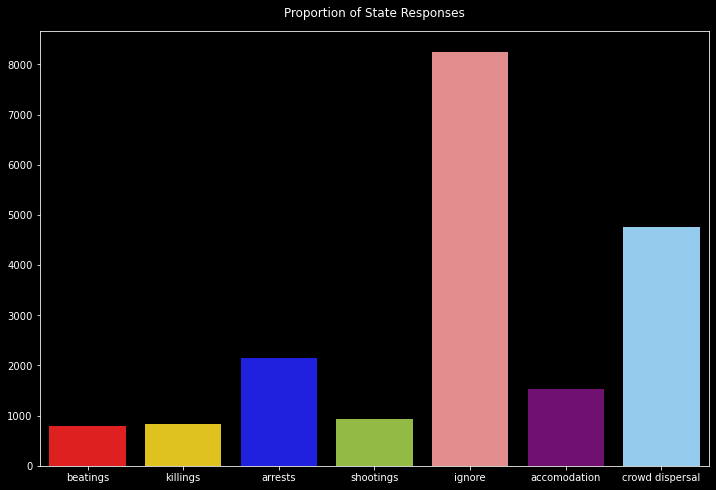

In [28]:
bar_labels = ['beatings', 'killings', 'arrests', 'shootings', 'ignore', 'accomodation', 'crowd dispersal']
bar_sizes = [df['beatings'].value_counts()[1], 
         df['killings'].value_counts()[1],
         df['arrests'].value_counts()[1], 
         df['shootings'].value_counts()[1], 
         df['ignore'].value_counts()[1],
         df['accomodation'].value_counts()[1],
         df['crowd dispersal'].value_counts()[1]]



bar_colors = ['red', 'gold', 'blue', 'yellowgreen', 'lightcoral', 'purple', 'lightskyblue']

plt.figure(figsize=(12,8))

plt.title('Proportion of State Responses', pad=14)

sns.barplot(x=bar_labels, y=bar_sizes, palette=sns.color_palette(['red', 'gold', 'blue', 'yellowgreen', 'lightcoral', 'purple', 'lightskyblue'])
)

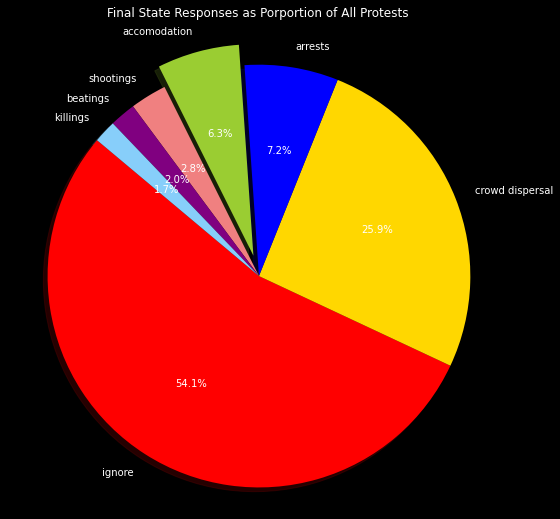

In [29]:
fin_labels = ['ignore', 'crowd dispersal', 'arrests', 'accomodation',
'shootings', 'beatings', 'killings']
fin_vals = df['final'].value_counts()[0:7]

pie_colors = ['red', 'gold', 'blue', 'yellowgreen', 'lightcoral', 'purple', 'lightskyblue']
explode = (0, 0, 0, 0.1, 0, 0, 0)  # explode 1st slice

plt.figure(figsize=(9,9))

plt.title('Final State Responses as Porportion of All Protests')

plt.pie(fin_vals, explode=explode, labels=fin_labels, colors=pie_colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

C:\Users\catal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


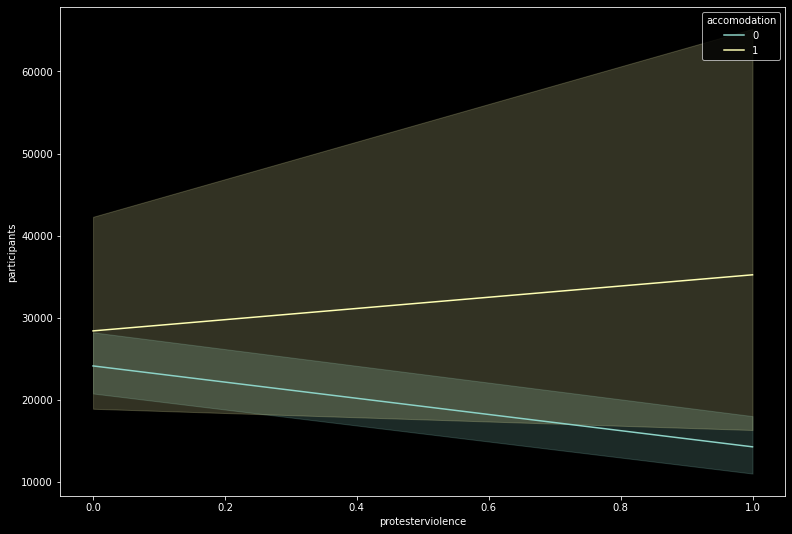

In [30]:
# J's plot, succcess by number of participants & violence

fig, ax = plt.subplots(figsize=(13,9))

sns.lineplot('protesterviolence', 'participants', hue='accomodation',
             markers=['o','o'],
             dashes=[(1, 1), (5, 10)],
             ax=ax,
             data=df);

C:\Users\catal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


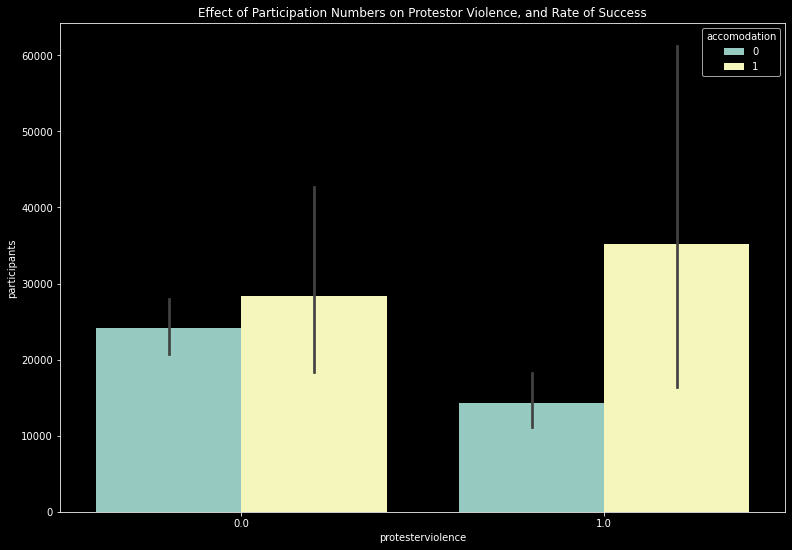

In [31]:
# same plot, different way
fig, ax = plt.subplots(figsize=(13,9))

plt.title("Effect of Participation Numbers on Protestor Violence, and Rate of Success")

sns.barplot('protesterviolence', 'participants', hue='accomodation',
             ax=ax,
             data=df);

C:\Users\catal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


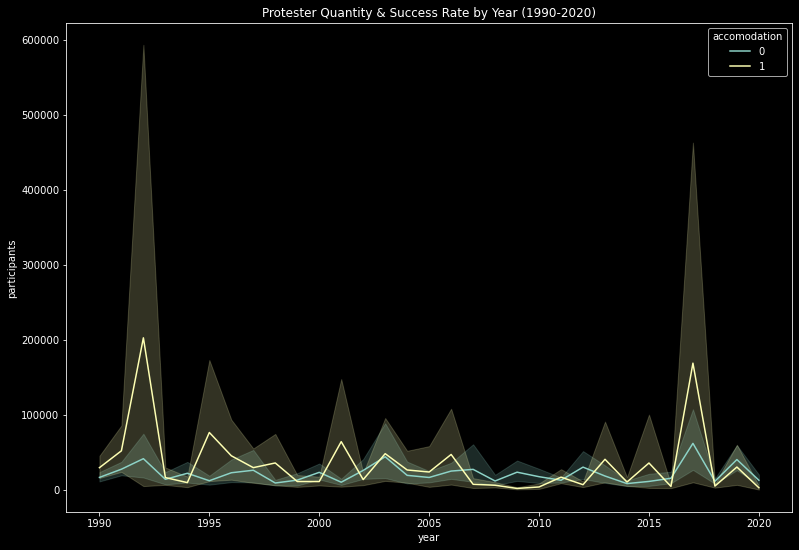

In [32]:
# J's plot overview of no. protests by year, participant count, and success/not
fig, ax = plt.subplots(figsize=(13,9))

plt.title("Protester Quantity & Success Rate by Year (1990-2020)")

sns.lineplot('year', 'participants', hue='accomodation',
             markers=['o','o'],
             dashes=[(1, 1), (5, 10)],
             ax=ax,
             data=df);

One of the notable things here is a brief period, approximately 2003-2004, where about 50% of all protests actually succeeded in their aims.  Let's see if we can learn more about that.

In [33]:
# J's feature extraction on early-mid aughts success rate
successful = df['accomodation'] == 1
year1 = df['year'] > 2002
year2 = df['year'] < 2005
mid_00s_successes = df.loc[successful & year1 & year2]

In [34]:
mid_00s_successes['accomodation'].value_counts().sum()

92

<AxesSubplot:>

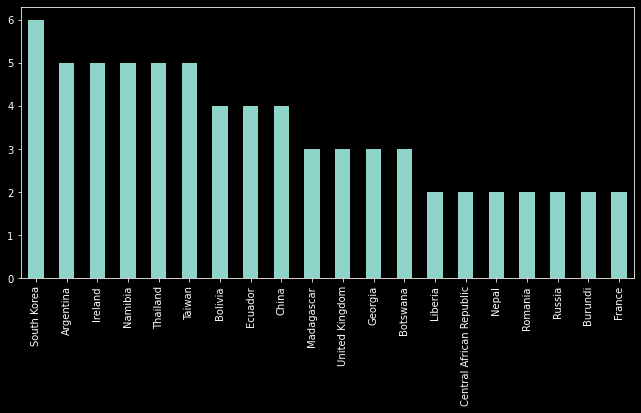

In [35]:
mid_00s_successes['country'].value_counts().head(20).plot(kind='bar', figsize=(11,5))

In [36]:
# # J's drilldown on specific issues in top-reforming countries 2003-2004
# korea_protests = mid_00s_successes.loc[(mid_00s_successes['country'] == 'South Korea')]
# korea_notes = korea_protests['notes']
# korea_notes.iloc[3]

# taiwan_protests = mid_00s_successes.loc[(mid_00s_successes['country'] == 'Taiwan')]
# taiwan_notes = taiwan_protests['notes']
# taiwan_notes.iloc[0]

# namib_protests = mid_00s_successes.loc[(mid_00s_successes['country'] == 'Namibia')]
# namib_notes = namib_protests['notes']
# namib_notes.iloc[3]

# ireland_protests = mid_00s_successes.loc[(mid_00s_successes['country'] == 'Ireland')]
# ireland_notes = ireland_protests['notes']
# ireland_notes.iloc[2]

# thai_protests = df.loc[(df['country'] == 'Thailand') & (df['accomodation'] == 1) & ((df['year'] > 2002) | (df['year'] < 2005))]
# thai_notes = thai_protests['notes']
# thai_notes.iloc[4]

- Korean farmers vs. free trade agreement with Chile.  Strong rural opposition.
- Disputed election in Taiwan
- Namibia, drought relief, AIDS, women’s demonstration against rape, abuse, rampant drug addiction.
- Ireland - “tractorcade”.  Participants: 2,000 tractors.

## Modeling

### Baseline

In [ ]:
df['accomodationomodationcommodation'].value_counts(normalize = True)

### Logistic Regression

We selected a Logistic Regression model as our primary modeling technique, in the interest of extracting interpretable coefficients.  

Achieving predictive power was secondary, and yet we achieved 93.9% test accuracy with the LogReg model.

A few other techniques may have offered slight improvements, but given the marginal gains we elected to focus on feature extraction and engineering to improve the LogReg.

In [37]:
# Noah's Logistic Regression

In [38]:
features = ['participants','protestnumber','protesterviolence','ignore','crowd dispersal',
     'arrests','shootings','beatings','killings','political behavior, process',
     'labor wage dispute','price increases, tax policy','removal of politician',
     'police brutality','land farm issue','social restrictions',
     'net_migration_per_1000_population','mean_age',
     'gdp_purchasing_power_global_rank','gdp_growth_global_rank','electricity_access_percent',
     'electricity_generating_capacity_global_rank','internet_access_percent','cell_phone_per_100',
     'natural_resources','language','govt_type']

In [39]:
X = world[features]
y = world['accommodation']

In [40]:
X = pd.get_dummies(X, drop_first = True)

X.fillna(X.mean(), inplace = True)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28)

In [42]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [43]:
logreg = LogisticRegression(solver = 'liblinear')

In [44]:
logreg.fit(Xs_train, y_train)

LogisticRegression(solver='liblinear')

In [45]:
logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)

(0.9497981393715991, 0.9323506185838378)

In [46]:
preds = logreg.predict(Xs_test)

              precision    recall  f1-score   support

     Failure       0.94      0.99      0.96      3405
     Success       0.79      0.47      0.59       394

    accuracy                           0.93      3799
   macro avg       0.87      0.73      0.78      3799
weighted avg       0.93      0.93      0.92      3799



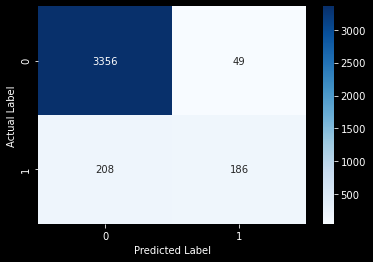

In [47]:
evaluation(y_test, preds)

### RNN

We ran an RNN on the protest data testing the hypothesis that previous recent protests might affect the outcome of the current one. That doesn't appear to be the case given the model's results (although it is slightly better than the baseline.)

In [48]:
# David's RNN

In [49]:
df['year'] = pd.to_datetime(df['year'])

In [50]:
df.set_index('year', inplace=True)
df.sort_index(inplace=True)

In [51]:
nn_X = df.drop(columns=['climate', 'natural_resources', 'population_distribution', 'net_migration_per_1000_population','language', 'legal_system',  'accomodation', 'country', 'location', 'participants', 'protesteridentity', 'sources', 'notes', 'final', 'electricity_generating_capacity_global_rank', 'transnational_disputes', 'military_spending_annual_percent_gdp'])
nn_y = df['accomodation']

In [52]:
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(nn_X, nn_y, shuffle=False, random_state=12)
nn_X_train.index[-1], nn_X_test.index[0]

(Timestamp('1970-01-01 00:00:00.000002014'),
 Timestamp('1970-01-01 00:00:00.000002014'))

In [53]:
ss = StandardScaler()
nn_X_train_sc = ss.fit_transform(nn_X_train)
nn_X_test_sc = ss.transform(nn_X_test)

In [54]:
train_sequences = TimeseriesGenerator(nn_X_train_sc, nn_y_train, length=3, batch_size=64)
test_sequences = TimeseriesGenerator(nn_X_test_sc, nn_y_test, length=3, batch_size=64)

In [55]:
input_shape = train_sequences[0][0][0].shape

model1 = Sequential()
model1.add(GRU(128, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model1.add(GRU(64, return_sequences=False))                         # False if next layer is Dense
model1.add(Dense(32, activation='relu'))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer = Adam(lr=0.0005), loss='binary_crossentropy', metrics=['acc', ])

history = model1.fit(train_sequences, validation_data=test_sequences, batch_size=64, epochs=50, verbose=0)

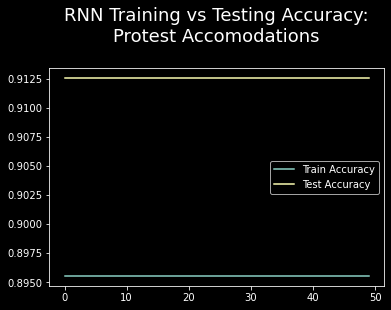

In [56]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.title('RNN Training vs Testing Accuracy:\nProtest Accomodations\n', fontsize=18)
plt.legend();

In [57]:
model2 = Sequential()
model2.add(GRU(128, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model2.add(GRU(64, return_sequences=True))
model2.add(GRU(32, return_sequences=False)) # False if next layer is Dense
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(patience = 5)

history2 = model2.fit(train_sequences, validation_data=test_sequences, epochs=50, batch_size=64, callbacks = [es], verbose=True)

Epoch 1/50
178/178 [==============================] - 7s 11ms/step - loss: nan - acc: 0.8920 - val_loss: nan - val_acc: 0.9125
Epoch 2/50
178/178 [==============================] - 1s 6ms/step - loss: nan - acc: 0.8955 - val_loss: nan - val_acc: 0.9125
Epoch 3/50
178/178 [==============================] - 1s 6ms/step - loss: nan - acc: 0.8940 - val_loss: nan - val_acc: 0.9125
Epoch 4/50
178/178 [==============================] - 1s 7ms/step - loss: nan - acc: 0.9000 - val_loss: nan - val_acc: 0.9125
Epoch 5/50
178/178 [==============================] - 1s 7ms/step - loss: nan - acc: 0.8956 - val_loss: nan - val_acc: 0.9125


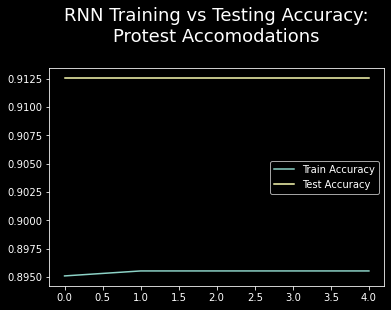

In [58]:
plt.plot(history2.history['acc'], label='Train Accuracy')
plt.plot(history2.history['val_acc'], label='Test Accuracy')
plt.title('RNN Training vs Testing Accuracy:\nProtest Accomodations\n', fontsize=18)
plt.legend();

### K-means Clustering

In addition to predictive modeling, we hoped to extract additional insights from the data via unsupervised learning.  K-means clustering showed an interesting trend between overall participation in protests and the mean_age of a given country.  

Broadly speaking, smaller and less successful protests are a feature of countries with a younger population, mainly the teens-twenties age range.  As the mean_age of the country increases, there tend to be fewer protests, *but* they tend to be larger and more successful.

However, at the high end of the scale, the mean_age trends back toward the overall median, simply due to the larger sample size.  The largest protests are the ones that do not particularly correlate to age.

In [59]:
# J's Kmeans clustering

In [60]:
X_kmeans = df.loc[:, ['mean_age', 'participants']]

In [61]:
ss = StandardScaler()
Xs_kmeans = ss.fit_transform(X_kmeans)

In [62]:
kmeans = KMeans(6, random_state=42, n_init=25, tol=0.001)
kmeans.fit(Xs_kmeans)

KMeans(n_clusters=6, n_init=25, random_state=42, tol=0.001)

In [63]:
kmeans.cluster_centers_

array([[-1.30311064e+00, -9.44284024e-02],
       [ 1.10358626e+00, -5.09227260e-02],
       [ 5.40271841e-01,  1.44341154e+01],
       [-2.62581111e-02,  3.02132589e+01],
       [-1.71071532e-01, -6.14366393e-02],
       [ 4.81457970e-01,  3.97708176e+00]])

In [64]:
centroids = pd.DataFrame(
    ss.inverse_transform(kmeans.cluster_centers_),
    columns= ['mean_age', 'participants']
)
centroids

,mean_age,participants
0,24.610261,5.430930e+03
1,39.457562,1.324643e+04
2,35.982385,2.615385e+06
3,32.487370,5.450000e+06
4,31.593993,1.135767e+04
5,35.619552,7.368499e+05


In [65]:
df['cluster'] = kmeans.labels_

''

<Figure size 648x648 with 0 Axes>

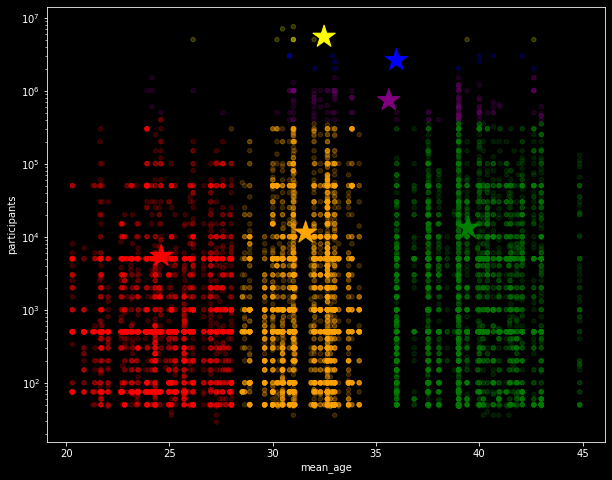

In [66]:
plt.figure(figsize=(9,9));

## Plot scatter by cluster / color, and centroids
colors = ["red", "green", "blue", "yellow", "orange", "purple"]
df['color'] = df['cluster'].map(lambda p: colors[p])

ax = df.plot(
    kind="scatter", 
    x="mean_age", y="participants",
    figsize=(10,8),
    c = df['color'], 
    alpha=0.2,
    logy = True
)

centroids.plot(
    kind="scatter", 
    x="mean_age", y="participants", 
    marker="*", c=["r", "g", "b", "yellow", "orange", "purple"], s=550,
    ax=ax,
)

plt.xticks(range(20, 50, 5))
;

### Sentiment Analysis

In [ ]:
sent_scores = []

In [ ]:
# takes 35+ minutes to run, execute at your own risk
for i in range(len(df)):
    sent_scores.append(sent_scorer(df, i))

In [104]:
df['sent_score'] = sent_scores

<AxesSubplot:title={'center':'Proportion of State Responses'}>

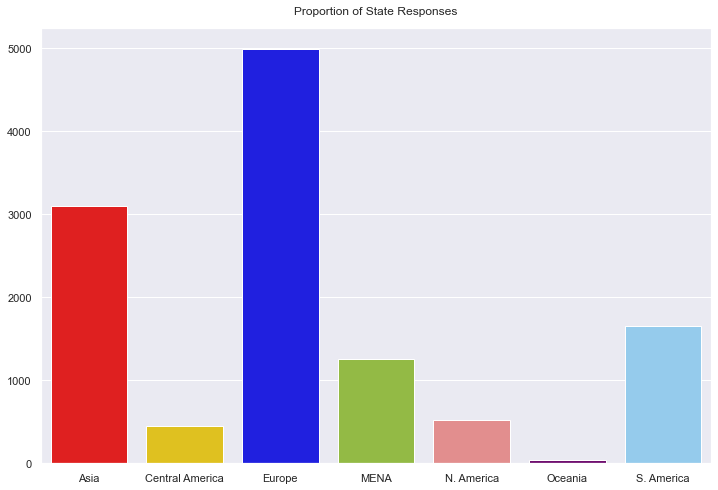

In [132]:
# Sentiment Scores by Region
region_labels = ['Asia', 'Central America', 'Europe', 'MENA', 'N. America', 'Oceania', 'S. America']
regions = [df['region_Asia'].value_counts()[1], 
         df['region_Central America'].value_counts()[1],
         df['region_Europe'].value_counts()[1], 
         df['region_MENA'].value_counts()[1], 
         df['region_North America'].value_counts()[1],
         df['region_Oceania'].value_counts()[1],
         df['region_South America'].value_counts()[1]]

plt.figure(figsize=(12,8))

plt.title('Proportion of State Responses', pad=14)

sns.barplot(x=region_labels, y=regions, palette=sns.color_palette(['red', 'gold', 'blue', 'yellowgreen', 'lightcoral', 'purple', 'lightskyblue'])
)

### Word2Vec

## Modeling Results

In [67]:
# initial and regional top and bottom 15 analysis done by Noah

In [68]:
feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

In [69]:
top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]

In [70]:
regions = [africa, asia, cen_am, europe, mena, nor_am, oceania, sou_am, world]

In [71]:
for i in range(len(regions)):
    regions[i]['participants'] = regions[i]['participants'].map(part_dic)

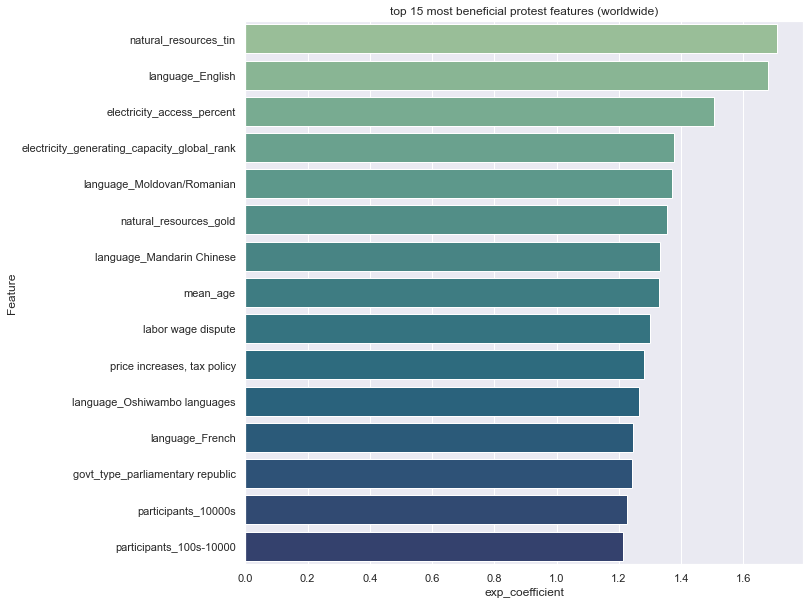

In [72]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (worldwide)');

In [73]:
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

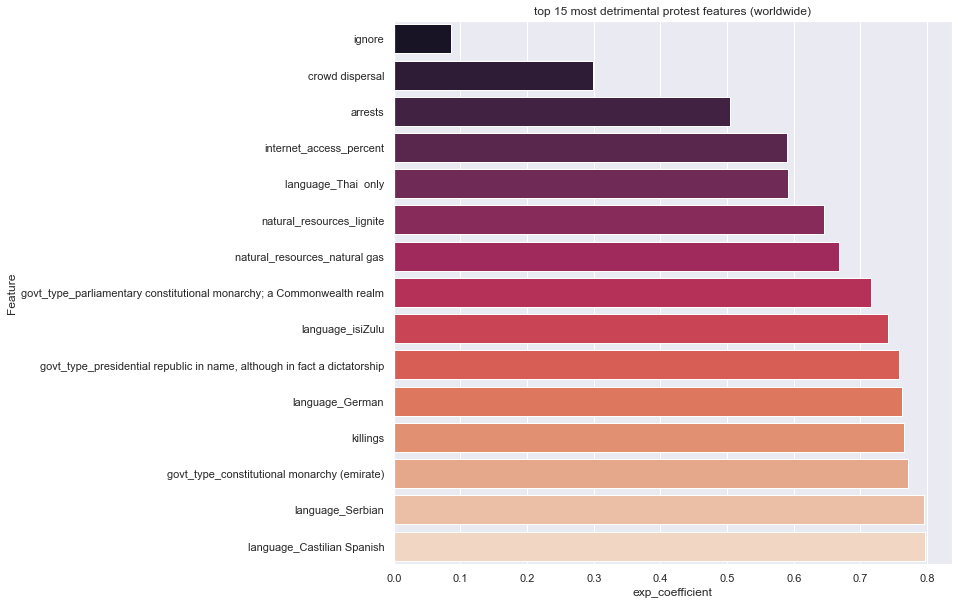

In [74]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')
plt.title('top 15 most detrimental protest features (worldwide)');

In [75]:
# I have no clue why but I could not get this to work in a for loop.

africa['mean_age'] = 0
for i in range(0, africa.shape[0]):
    africa['mean_age'][i] = ((africa['age_0_14_percent'][i] / 100) * 7) + ((africa['age_15_24_percent'][i] / 100) * 19) + ((africa['age_25_54_percent'][i] / 100) * 39) + ((africa['age_55_64_percent'][i] / 100) * 59)+ ((africa['age_65_over_percent'][i] / 100) * 71);

asia['mean_age'] = 0
for i in range(0, asia.shape[0]):
    asia['mean_age'][i] = ((asia['age_0_14_percent'][i] / 100) * 7) + ((asia['age_15_24_percent'][i] / 100) * 19) + ((asia['age_25_54_percent'][i] / 100) * 39) + ((asia['age_55_64_percent'][i] / 100) * 59)+ ((asia['age_65_over_percent'][i] / 100) * 71);

cen_am['mean_age'] = 0
for i in range(0, cen_am.shape[0]):
    cen_am['mean_age'][i] = ((cen_am['age_0_14_percent'][i] / 100) * 7) + ((cen_am['age_15_24_percent'][i] / 100) * 19) + ((cen_am['age_25_54_percent'][i] / 100) * 39) + ((cen_am['age_55_64_percent'][i] / 100) * 59)+ ((cen_am['age_65_over_percent'][i] / 100) * 71);

europe['mean_age'] = 0
for i in range(0, europe.shape[0]):
    europe['mean_age'][i] = ((europe['age_0_14_percent'][i] / 100) * 7) + ((europe['age_15_24_percent'][i] / 100) * 19) + ((europe['age_25_54_percent'][i] / 100) * 39) + ((europe['age_55_64_percent'][i] / 100) * 59)+ ((europe['age_65_over_percent'][i] / 100) * 71);

mena['mean_age'] = 0
for i in range(0, mena.shape[0]):
    mena['mean_age'][i] = ((mena['age_0_14_percent'][i] / 100) * 7) + ((mena['age_15_24_percent'][i] / 100) * 19) + ((mena['age_25_54_percent'][i] / 100) * 39) + ((mena['age_55_64_percent'][i] / 100) * 59)+ ((mena['age_65_over_percent'][i] / 100) * 71);

nor_am['mean_age'] = 0
for i in range(0, nor_am.shape[0]):
    nor_am['mean_age'][i] = ((nor_am['age_0_14_percent'][i] / 100) * 7) + ((nor_am['age_15_24_percent'][i] / 100) * 19) + ((nor_am['age_25_54_percent'][i] / 100) * 39) + ((nor_am['age_55_64_percent'][i] / 100) * 59)+ ((nor_am['age_65_over_percent'][i] / 100) * 71);

oceania['mean_age'] = 0
for i in range(0, oceania.shape[0]):
    oceania['mean_age'][i] = ((oceania['age_0_14_percent'][i] / 100) * 7) + ((oceania['age_15_24_percent'][i] / 100) * 19) + ((oceania['age_25_54_percent'][i] / 100) * 39) + ((oceania['age_55_64_percent'][i] / 100) * 59)+ ((oceania['age_65_over_percent'][i] / 100) * 71);

sou_am['mean_age'] = 0
for i in range(0, sou_am.shape[0]):
    sou_am['mean_age'][i] = ((sou_am['age_0_14_percent'][i] / 100) * 7) + ((sou_am['age_15_24_percent'][i] / 100) * 19) + ((sou_am['age_25_54_percent'][i] / 100) * 39) + ((sou_am['age_55_64_percent'][i] / 100) * 59)+ ((sou_am['age_65_over_percent'][i] / 100) * 71);

<ipython-input-75-9979c44e5cf0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  africa['mean_age'][i] = ((africa['age_0_14_percent'][i] / 100) * 7) + ((africa['age_15_24_percent'][i] / 100) * 19) + ((africa['age_25_54_percent'][i] / 100) * 39) + ((africa['age_55_64_percent'][i] / 100) * 59)+ ((africa['age_65_over_percent'][i] / 100) * 71);
C:\Users\catal\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-75-9979c44e5cf0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

### Region: Africa

Africa: (0.9367671691792295, 0.9246231155778895)


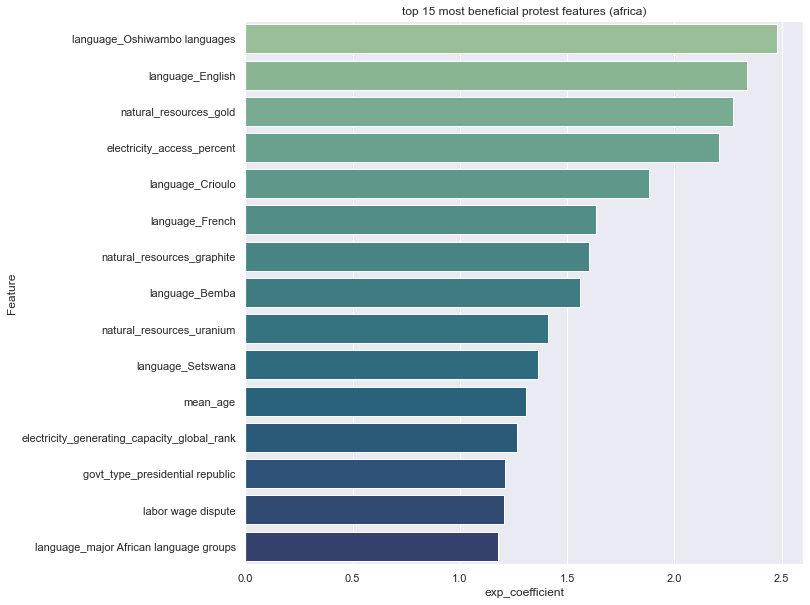

In [76]:
X = africa[features]
y = africa['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'Africa: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (africa)');

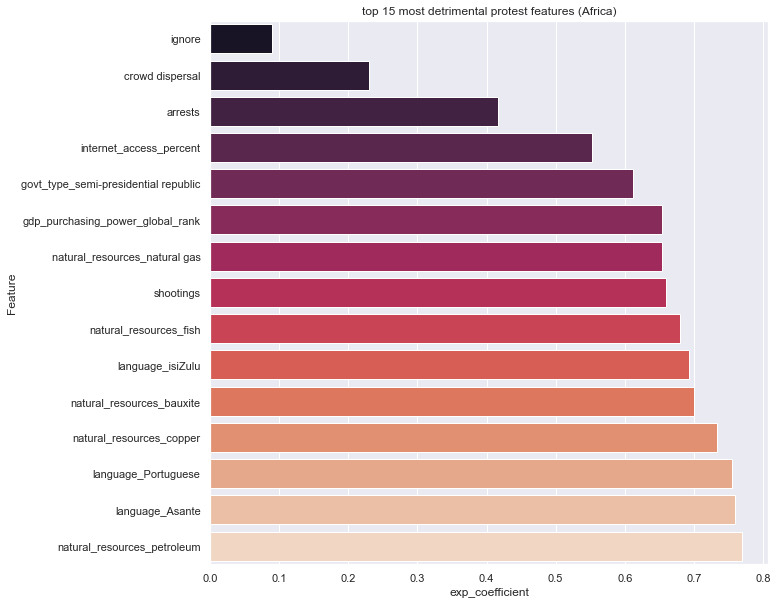

In [77]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')
plt.title('top 15 most detrimental protest features (Africa)');

### Region: Asia

In [78]:
def too_long(string):
    if len(string) >= 45:
        return string[:45]

In [79]:
asia['govt_type'].value_counts()

federal parliamentary republic                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     610
parliamentary republic                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [80]:
string = 'federal parliamentary constitutional monarchy\nnote: all Peninsular Malaysian states have hereditary rulers (commonly referred to as sultans) except Melaka (Malacca) and Pulau Pinang (Penang); those two states along with Sabah and Sarawak in East Malaysia have governors appointed by government; powers of state governments are limited by the federal constitution; under terms of federation, Sabah and Sarawak retain certain constitutional prerogatives (e.g., right to maintain their own immigration controls) 148 parliamentary constitutional monarchy' 

In [81]:
len(string.split())

73

asia: (0.9293712316968131, 0.9263565891472868)


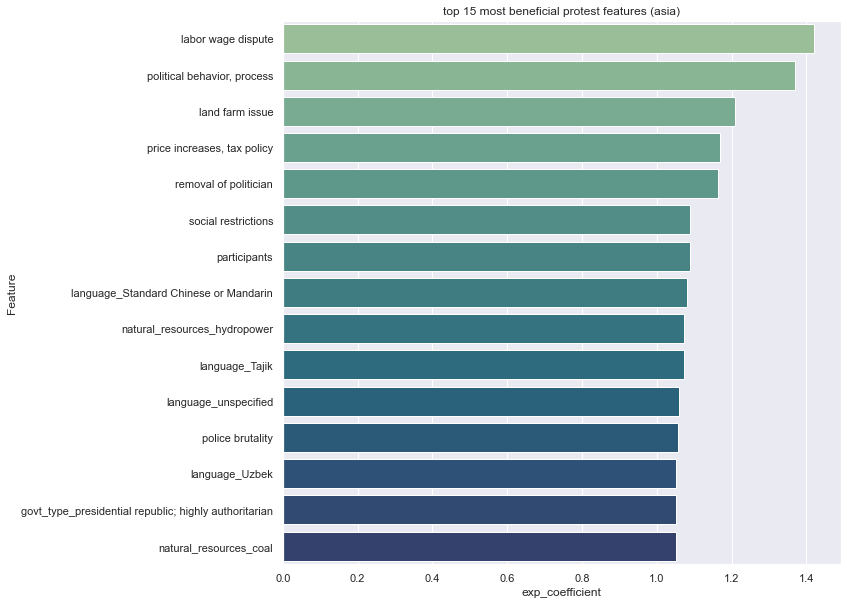

In [82]:
X = asia[features]
y = asia['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'asia: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (asia)');

C:\Users\catal\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\catal\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


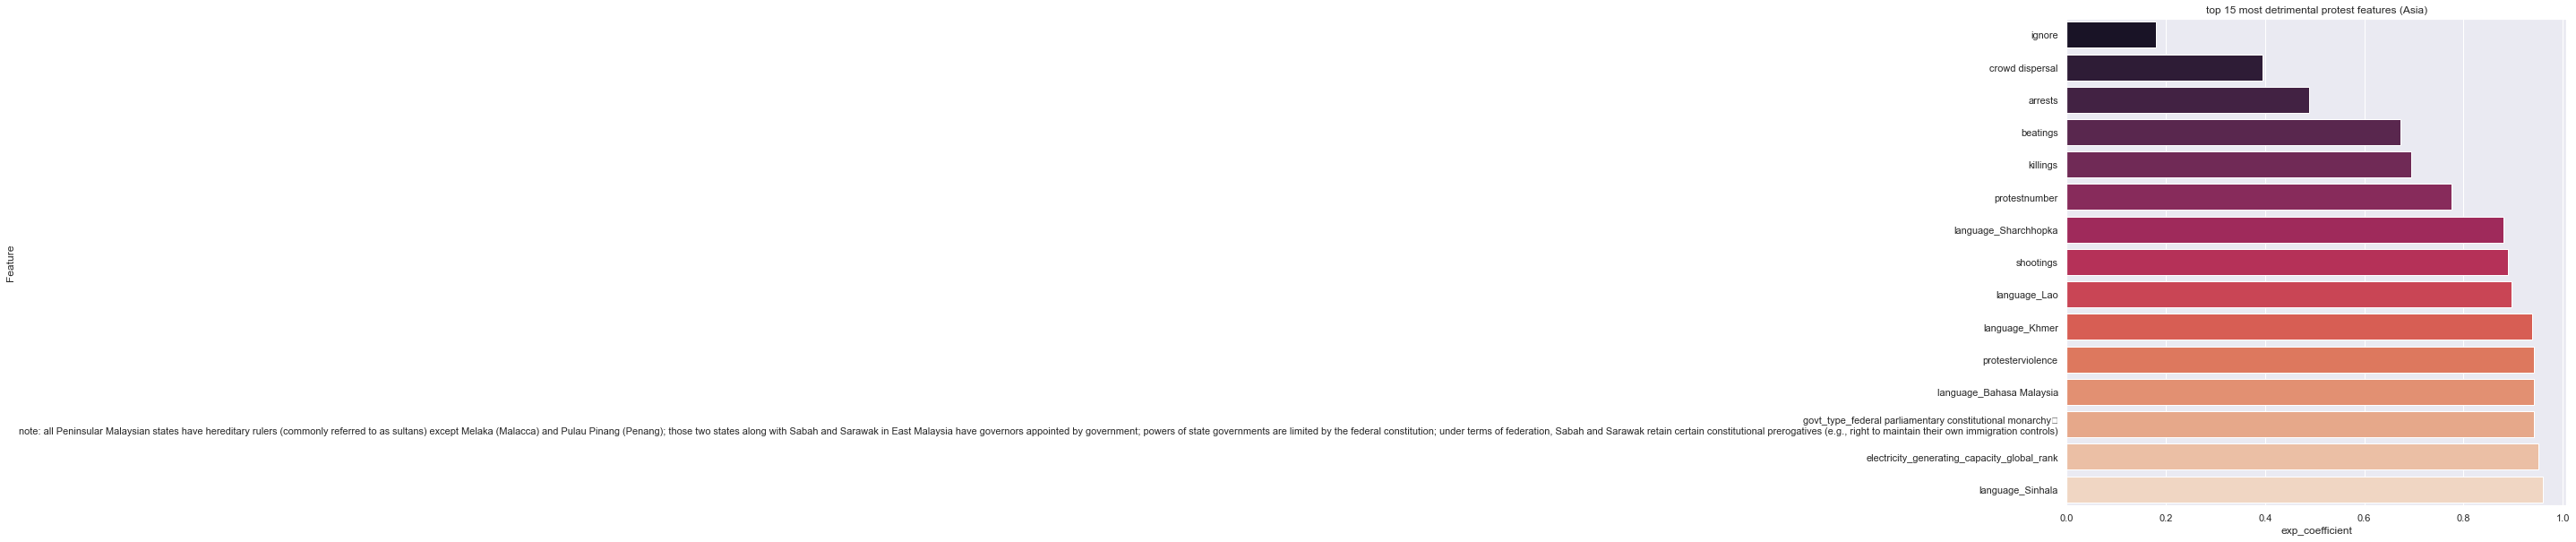

In [83]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')

plt.title('top 15 most detrimental protest features (Asia)');

### Region: Central America

cen_am: (0.9554896142433235, 0.9469026548672567)


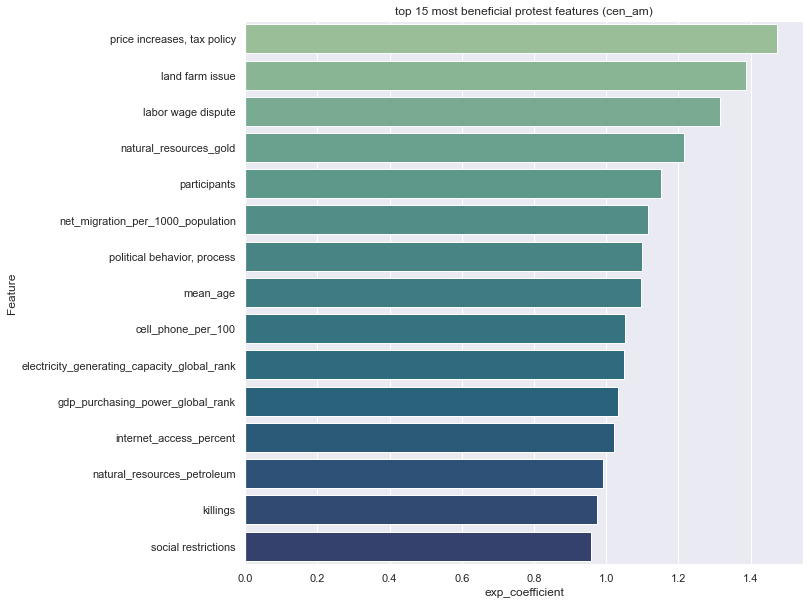

In [84]:
X = cen_am[features]
y = cen_am['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'cen_am: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (cen_am)');

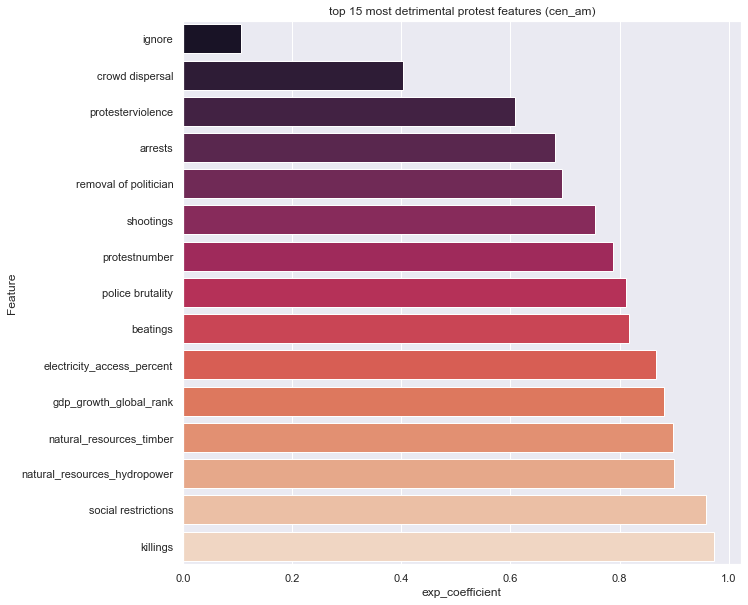

In [85]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')

plt.title('top 15 most detrimental protest features (cen_am)');

### Region: Europe

europe: (0.9657845495856723, 0.9607371794871795)


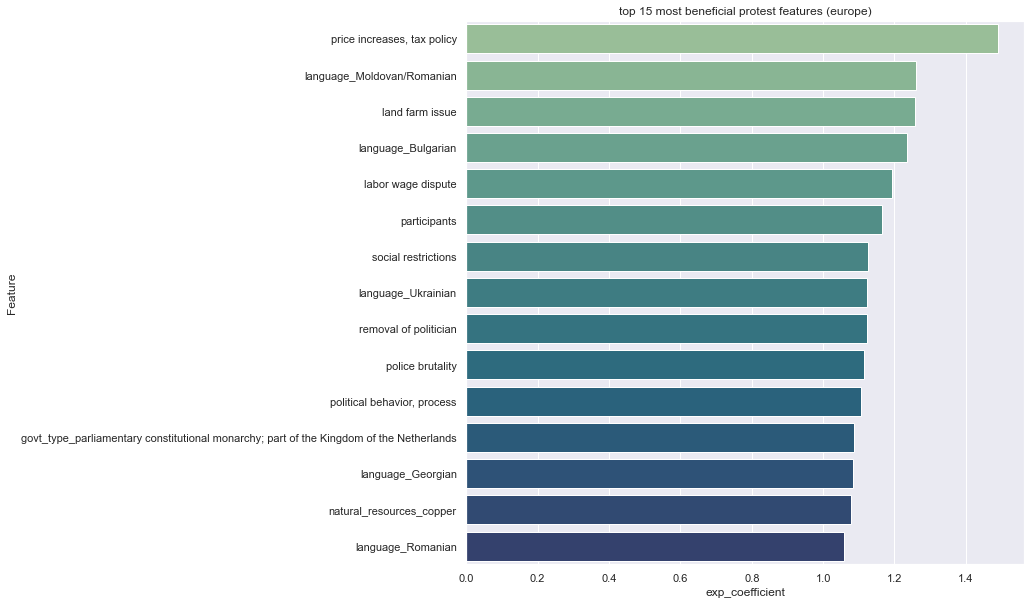

In [86]:
X = europe[features]
y = europe['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'europe: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (europe)');

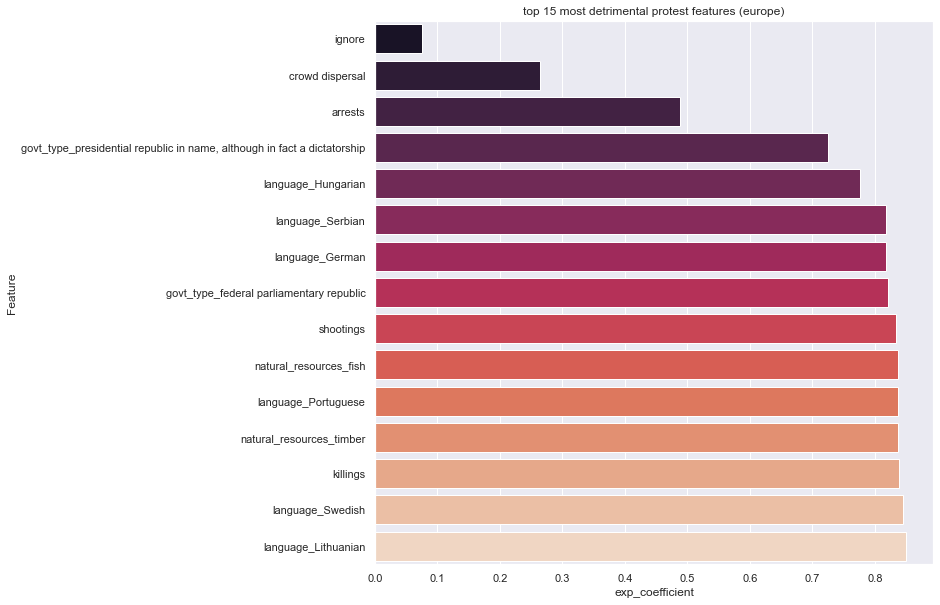

In [87]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')

plt.title('top 15 most detrimental protest features (europe)');

### Region: ME-NA (Middle-East, North Africa)

mena: (0.940552016985138, 0.9396825396825397)


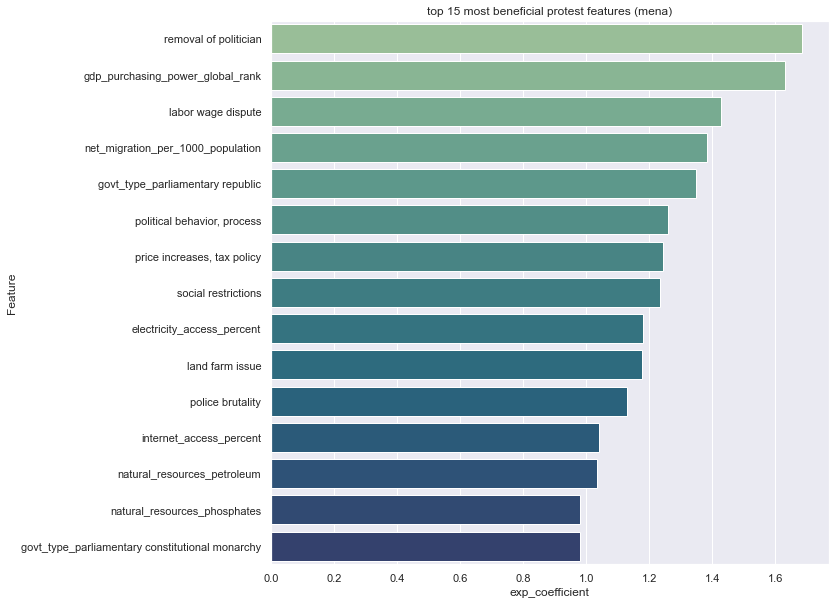

In [88]:
X = mena[features]
y = mena['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'mena: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (mena)');

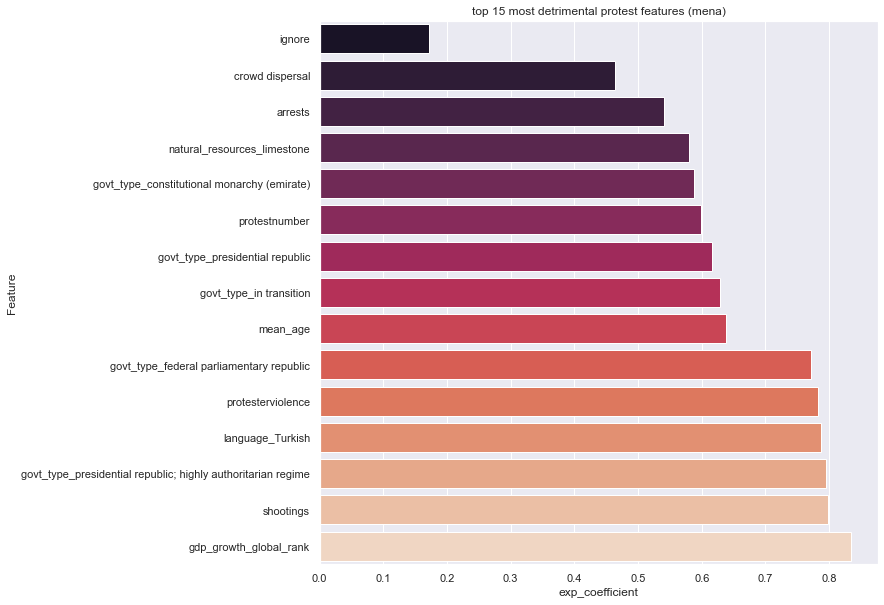

In [89]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')

plt.title('top 15 most detrimental protest features (mena)');

### Region: North America

nor_ama: (0.9643765903307888, 0.9242424242424242)


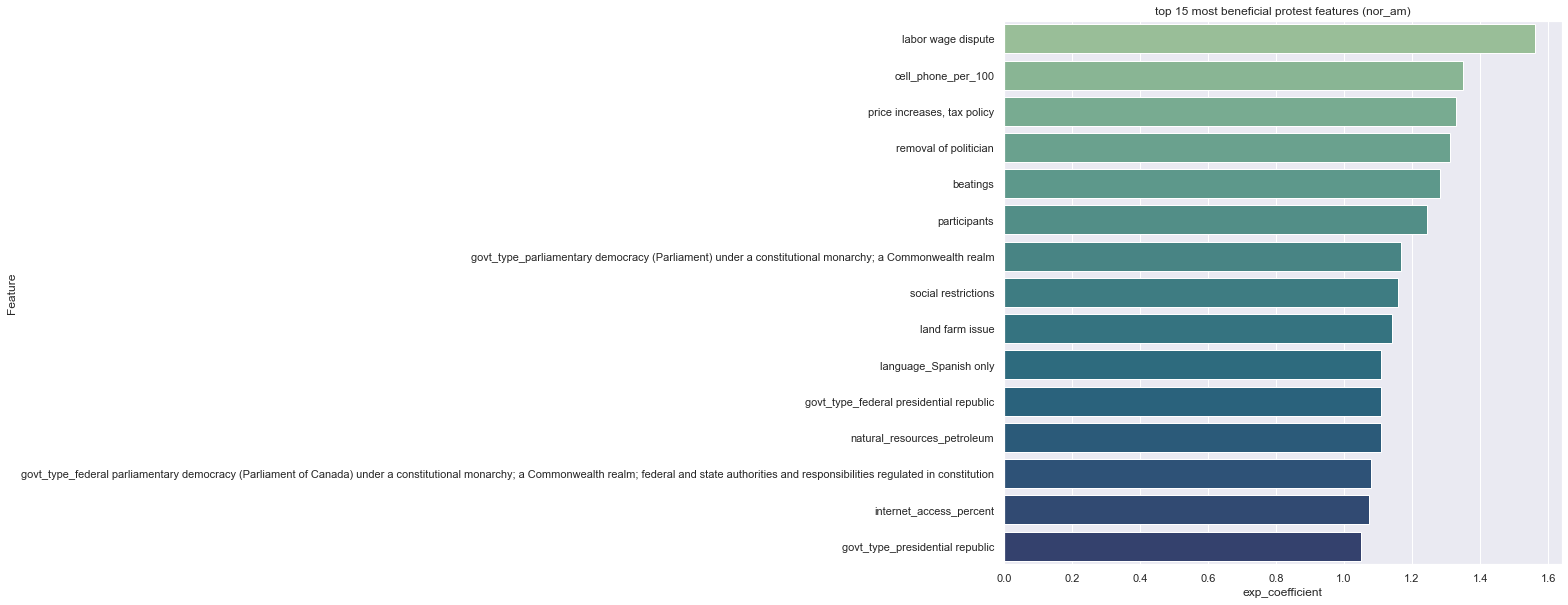

In [90]:
X = nor_am[features]
y = nor_am['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'nor_ama: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (nor_am)');

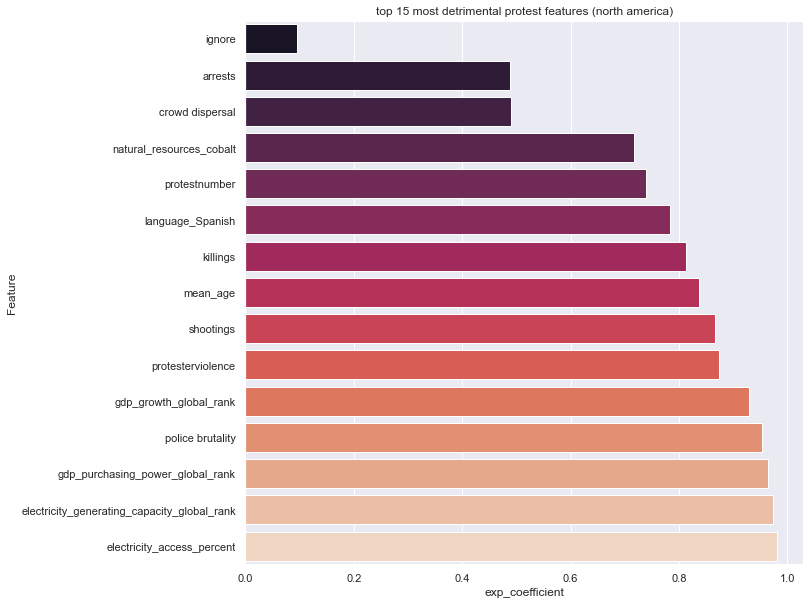

In [91]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')

plt.title('top 15 most detrimental protest features (north america)');

### Region: Oceania

oceania: (0.9285714285714286, 0.7)


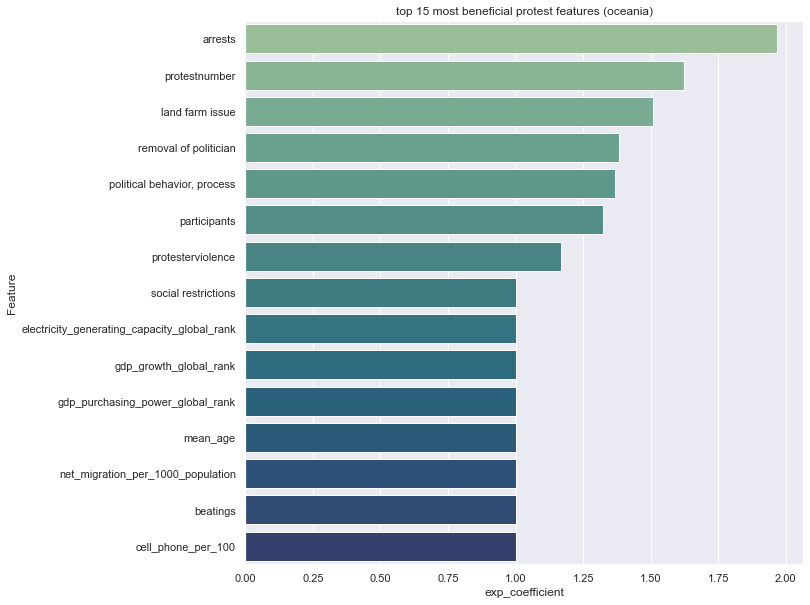

In [92]:
X = oceania[features]
y = oceania['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'oceania: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (oceania)');

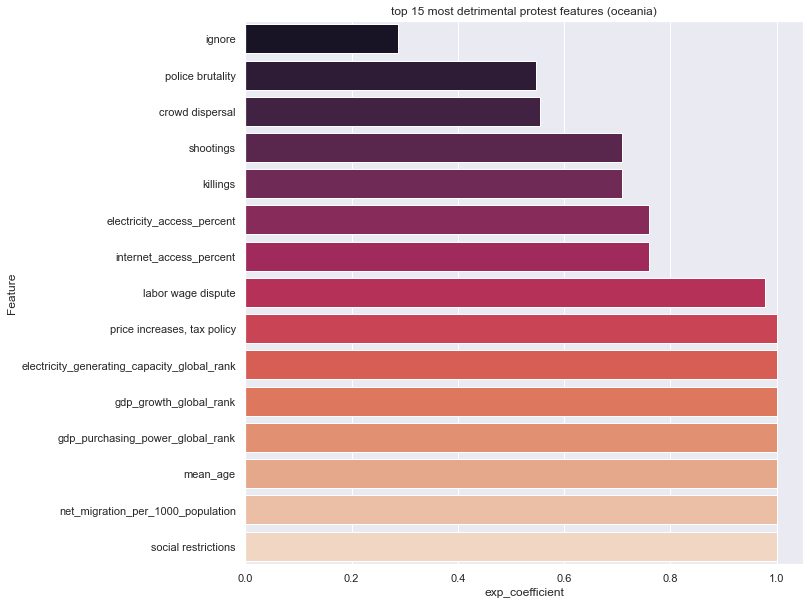

In [93]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')

plt.title('top 15 most detrimental protest features (oceania)');

### Region: South America

sou_am: (0.9314516129032258, 0.9468599033816425)


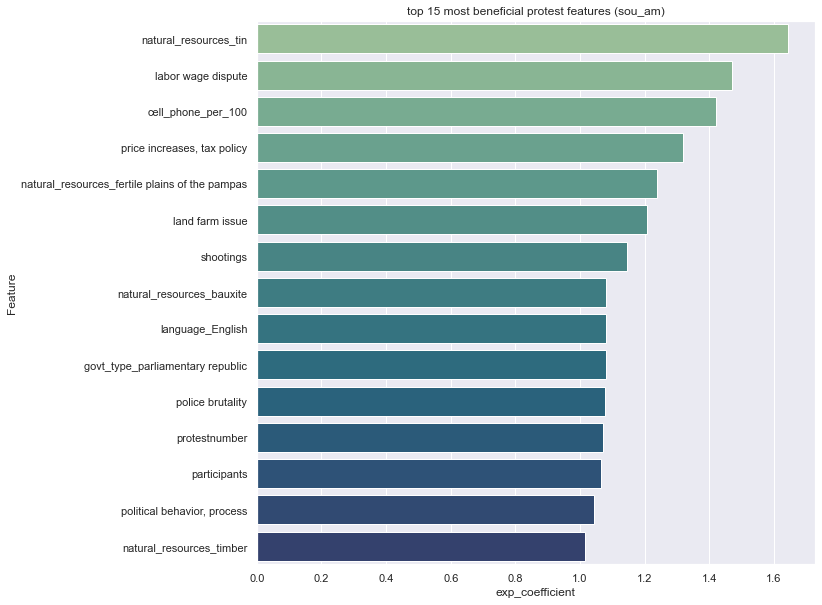

In [94]:
X = sou_am[features]
y = sou_am['accommodation']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'sou_am: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'crest')
plt.title('top 15 most beneficial protest features (sou_am)');

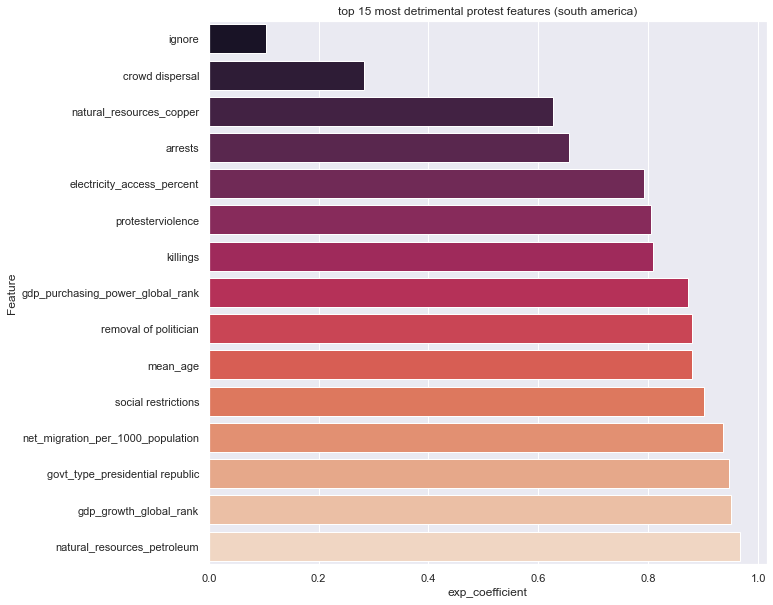

In [95]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'rocket')

plt.title('top 15 most detrimental protest features (south america)');

## Predicting and Preventing State Violence

In [96]:
new_features = [item for item in features if item != 'killings']

In [97]:
new_features.append('accommodation')

world: (0.9551518342987537, 0.9541984732824428)


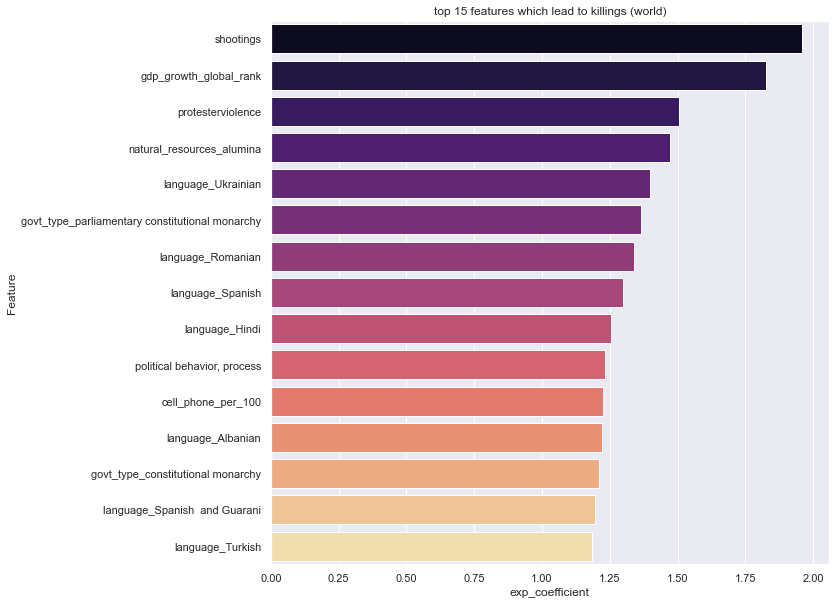

In [98]:
X = world[new_features]
y = world['killings']

X = pd.get_dummies(X, drop_first = True)
X.fillna(X.mean(), inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(Xs_train, y_train)
print(f'world: {logreg.score(Xs_train, y_train), logreg.score(Xs_test, y_test)}')

feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coef_df = pd.concat([feature_names, log_coef], axis = 1)

coef_df['absolute_coef'] = abs(coef_df['Coefficient'])

coef_df.set_index('Feature')

coef_df['exp_coefficient'] = np.exp(coef_df['Coefficient'])

top_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = False)[:15]
bottom_15 = coef_df.sort_values(by = 'exp_coefficient', ascending = True)[:15]

sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = top_15['exp_coefficient'],
           y = top_15['Feature'],
           palette = 'magma')
plt.title('top 15 features which lead to killings (world)');

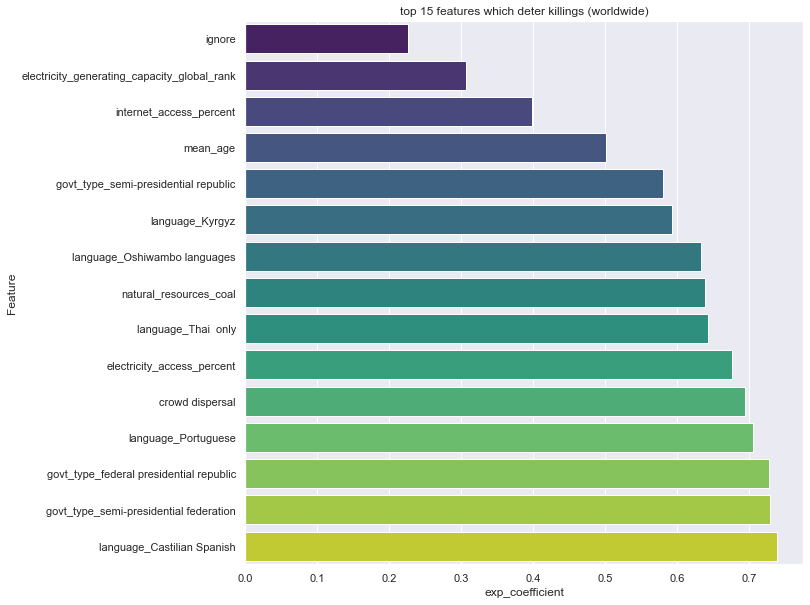

In [99]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x = bottom_15['exp_coefficient'],
           y = bottom_15['Feature'],
           palette = 'viridis')

plt.title('top 15 features which deter killings (worldwide)');

## Conclusions and Recommendations

#### Natural Resources & Language of a country are strong indicators of success
- This highlights the fact that many of the bitterest and most determined protests are in impoverished, post-colonial nations still suffering from a long history of economic exploitation, and often dictatorial governments.

#### Government responses have a strong chilling effect
- Arrests and Crowd Dispersal both have
- By far the best thing a government can do is if they want to suppress a protest is ignore it.
- The above is likely more an indication of the low effectiveness of the protest than the government's actions.

#### The factors in protest success are very distinct in different regions
- Many outliers within regions are post-colonial countries, standing out based on a particular natural resource or language.
- GDP growth, availability of electricity, and cell phones per capita were the most consistent factors across regions.